<a href="https://colab.research.google.com/github/littlekii/DPBBP/blob/main/calibration_SGD_SGLD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1) One can change SGD to SGLD by change the **arguments** in the privacy engine.

In [ ]:
!pip install opacus==0.13

     |████████████████████████████████| 102kB 5.2MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
"""
Runs MNIST training with differential privacy.

"""


import argparse

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from opacus import PrivacyEngine
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

# Precomputed characteristics of the MNIST dataset
MNIST_MEAN = 0.1307
MNIST_STD = 0.3081
torch.manual_seed(218)
torch.cuda.manual_seed(218)
np.random.seed(218)

#https://github.com/facebookresearch/pytorch-dp/blob/master/examples/mnist.py
class SampleConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 8, 2, padding=3)
        self.conv2 = nn.Conv2d(16, 32, 4, 2)
        self.fc1 = nn.Linear(32 * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        # x of shape [B, 1, 28, 28]
        x = F.relu(self.conv1(x))  # -> [B, 16, 14, 14]
        x = F.max_pool2d(x, 2, 1)  # -> [B, 16, 13, 13]
        x = F.relu(self.conv2(x))  # -> [B, 32, 5, 5]
        x = F.max_pool2d(x, 2, 1)  # -> [B, 32, 4, 4]
        x = x.view(-1, 32 * 4 * 4)  # -> [B, 512]
        x = F.relu(self.fc1(x))  # -> [B, 32]
        x = self.fc2(x)  # -> [B, 10]
        return x

    def name(self):
        return "MNISTConvNet"


class Linear_2L(nn.Module):
    def __init__(self):
        super(Linear_2L, self).__init__()
                
        self.fc1 = nn.Linear(784, 1200)
        self.fc2 = nn.Linear(1200, 1200)
        self.fc3 = nn.Linear(1200, 10)

    def forward(self, x):

        x = x.view(-1, 784) # view(batch_size, input_dim)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        y = self.fc3(x)
        return y
    def name(self):
        return "2L"
    

def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    criterion = nn.CrossEntropyLoss()
    losses = []
    for _batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    if not args.disable_dp:
        epsilon, best_alpha = optimizer.privacy_engine.get_privacy_spent(args.delta)
        print(
            f"Train Epoch: {epoch} \t"
            f"Loss: {np.mean(losses):.6f} "
            f"(ε = {epsilon:.2f}, δ = {args.delta}) for α = {best_alpha}"
        )
    else:
       epsilon = 0
       print(f"Train Epoch: {epoch} \t Loss: {np.mean(losses):.6f}")
    return np.mean(losses),epsilon

def test(args, model, device, test_loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for _batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()/60000*args.test_batch_size  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )
    return test_loss,correct/len(test_loader.dataset)



# dpsgd+2l+wd=0

/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:518: UserWarning: The sample rate will be defined from ``batch_size`` and ``sample_size``.The returned privacy budget will be incorrect.
  "The sample rate will be defined from ``batch_size`` and ``sample_size``."
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:195: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  wa

Train Epoch: 1 	Loss: 0.722246 (ε = 0.72, δ = 1e-05) for α = 18.0

Test set: Average loss: 0.0672, Accuracy: 8834/10000 (88.3400%)

Train Epoch: 2 	Loss: 0.426222 (ε = 0.76, δ = 1e-05) for α = 18.0

Test set: Average loss: 0.0693, Accuracy: 9012/10000 (90.1200%)

Train Epoch: 3 	Loss: 0.460438 (ε = 0.80, δ = 1e-05) for α = 18.0

Test set: Average loss: 0.0792, Accuracy: 9034/10000 (90.3400%)

Train Epoch: 4 	Loss: 0.494149 (ε = 0.84, δ = 1e-05) for α = 18.0

Test set: Average loss: 0.0837, Accuracy: 9061/10000 (90.6100%)

Train Epoch: 5 	Loss: 0.560830 (ε = 0.88, δ = 1e-05) for α = 17.0

Test set: Average loss: 0.0968, Accuracy: 9011/10000 (90.1100%)

Train Epoch: 6 	Loss: 0.617628 (ε = 0.91, δ = 1e-05) for α = 17.0

Test set: Average loss: 0.1169, Accuracy: 8930/10000 (89.3000%)

Train Epoch: 7 	Loss: 0.714312 (ε = 0.94, δ = 1e-05) for α = 17.0

Test set: Average loss: 0.1330, Accuracy: 8903/10000 (89.0300%)

Train Epoch: 8 	Loss: 0.811196 (ε = 0.97, δ = 1e-05) for α = 17.0

Test set:

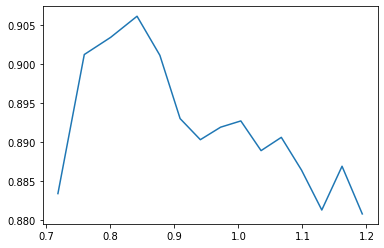

In [ ]:
class Args:
  batch_size=256;
  test_batch_size=1000;
  epochs=15
  n_runs=1
  lr=0.25 # lr SGD
  sigma=1.3
  max_per_sample_grad_norm=1.5
  delta=1e-5
  device='cuda'
  save_model=False
  disable_dp=False
  workers=2
  data_root='/mnist'

args = Args()
device = torch.device(args.device)


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        args.data_root,
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
            ]
        ),
    ),
    batch_size=args.batch_size,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        args.data_root,
        train=False,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
            ]
        ),
    ),
    batch_size=args.test_batch_size,
    shuffle=True,
)
        
tr_loss = np.zeros((args.n_runs,args.epochs))
te_loss = np.zeros((args.n_runs,args.epochs))
te_accu = np.zeros((args.n_runs,args.epochs))
eps = np.zeros((args.n_runs,args.epochs))
for run in range(args.n_runs):
    net = Linear_2L().to(device)

    optimizer = optim.SGD(net.parameters(), lr=args.lr,weight_decay =0.0)
    if not args.disable_dp:
        privacy_engine = PrivacyEngine(
            net,
            batch_size=args.batch_size,
            sample_size=len(train_loader.dataset),
            alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
            noise_multiplier=1.3,
            max_grad_norm=args.max_per_sample_grad_norm,
        )
        privacy_engine.attach(optimizer)
    for epoch in range(1, args.epochs + 1):
        tr_loss[run,epoch-1],eps[run,epoch-1]=train(args, net, device, train_loader, optimizer, epoch)
        te_loss[run,epoch-1],te_accu[run,epoch-1]=test(args, net, device, test_loader)

if args.n_runs > 1:
    print('Training loss: ',np.mean(tr_loss,axis=0),np.std(tr_loss,axis=0))
    print('Testing loss: ',np.mean(te_loss,axis=0),np.std(te_loss,axis=0))
    print('Testing accuracy: ',np.mean(te_accu,axis=0),np.std(te_accu,axis=0))

plt.plot(np.mean(eps,axis=0),np.mean(te_accu,axis=0))

repro_str = (
    f"{net.name()}_{args.lr}_{args.sigma}_"
    f"{args.max_per_sample_grad_norm}_{args.batch_size}_{args.epochs}_MNIST"
)
torch.save([tr_loss,te_loss,te_accu,eps], f"run_results_{repro_str}.pt")


100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


######## ECE: ##############
Local accuracy: 0.8808, predicted confidence 0.9863048032104968, ECE 0.10550480321049682


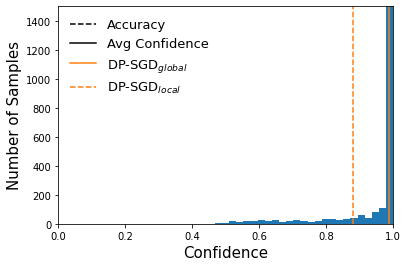

In [ ]:
model_local=net
model_local.eval()
y_local_te=np.empty((0,10))
y_local_te_single=np.array([])
targets_te=np.array([])
prob_local=np.array([])
with torch.no_grad():
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            output = model_local(data)
            y_local_te=np.append(y_local_te,F.softmax(output,dim=1).cpu().detach().numpy(),axis=0)
            y_local_te_single=np.append(y_local_te_single,F.softmax(output,dim=1).argmax(dim=1).cpu().detach().numpy())
            prob_local=np.append(prob_local,np.array([F.softmax(output,dim=1).cpu().detach().numpy()[i,j] for i,j in enumerate(target.cpu().detach().numpy())]))
            targets_te=np.append(targets_te,target.cpu().detach().numpy())


local_acc = np.mean(y_local_te_single == targets_te)
print("######## ECE: ##############")
print(f"Local accuracy: {local_acc}, predicted confidence {np.mean(np.max(y_local_te,axis=1))}, ECE {np.abs(local_acc - np.mean(np.max(y_local_te,axis=1)))}")


plt.plot(0,0,linestyle='dashed',color='black')
plt.plot(0,0,color='black')
plt.plot(0,0,color='#ff7f0e')
plt.plot([np.mean(targets_te==y_local_te_single)]*20,np.linspace(0,1500,20),linestyle='dashed',color='#ff7f0e',label='local Accu')
plt.plot([np.mean(np.max(y_local_te,axis=1))]*20,np.linspace(0,1500,20),color='#ff7f0e')

plt.hist([np.max(y_local_te,axis=1)],bins=30)
plt.ylim(0,1500)
plt.xlim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Number of Samples', fontsize=15)
plt.legend(('Accuracy','Avg Confidence',r'DP-SGD${}_{global}$',r'DP-SGD${}_{local}$'),fontsize=13,loc='upper left',frameon=False)
plt.savefig('Confidence_CIFAR10.pdf',format='pdf')
plt.show()


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


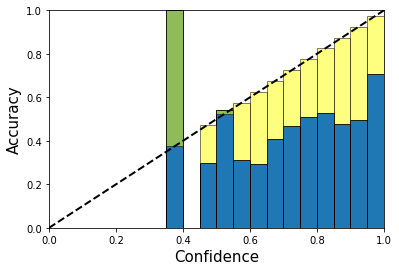

######## MCE: ##############
Local MCE: 0.625


In [ ]:
store_local=[]
templ=np.max(y_local_te,axis=1)
dr=0.05
for ratio in np.arange(0,1,dr):
    index=(templ>ratio)*(templ<ratio+dr)
    store_local.append(np.mean(y_local_te_single[index]==targets_te[index]))

# some has nan, replace with 0
store_local=np.array(store_local)
store_local[np.isnan(store_local)]=0
#%%
xaxis=np.arange(0,1,dr)+dr/2
plt.bar(xaxis[store_local!=0],store_local[store_local!=0],width=dr, edgecolor="black")
plt.bar(xaxis[store_local!=0],xaxis[store_local!=0]-store_local[store_local!=0],bottom=store_local[store_local!=0],width=dr, edgecolor="black",color='yellow',alpha=0.5)
plt.bar(10,10,bottom=store_local,width=dr, edgecolor="black",color='green',alpha=0.5)
plt.plot([0,1],[0,1],color='black',linewidth=2,linestyle='dashed')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
#plt.legend(('Perfect calibration','Accuracy','Over-confidence','Under-confidence'),fontsize=13,frameon=0)
plt.savefig('Confidence_CIFAR10_detail_LOCAL.pdf',format='pdf')
plt.show()
#%%
print("######## MCE: ##############")
print(f"Local MCE: {np.max(np.abs(xaxis[store_local!=0]-store_local[store_local!=0]))}")


# ndpsgd + 2l + wd = 0

Train Epoch: 1 	 Loss: 0.336618

Test set: Average loss: 0.0260, Accuracy: 9502/10000 (95.0200%)

Train Epoch: 2 	 Loss: 0.113570

Test set: Average loss: 0.0203, Accuracy: 9614/10000 (96.1400%)

Train Epoch: 3 	 Loss: 0.073954

Test set: Average loss: 0.0167, Accuracy: 9695/10000 (96.9500%)

Train Epoch: 4 	 Loss: 0.051253

Test set: Average loss: 0.0181, Accuracy: 9655/10000 (96.5500%)

Train Epoch: 5 	 Loss: 0.036439

Test set: Average loss: 0.0171, Accuracy: 9675/10000 (96.7500%)

Train Epoch: 6 	 Loss: 0.026074

Test set: Average loss: 0.0120, Accuracy: 9783/10000 (97.8300%)

Train Epoch: 7 	 Loss: 0.018411

Test set: Average loss: 0.0098, Accuracy: 9814/10000 (98.1400%)

Train Epoch: 8 	 Loss: 0.013227

Test set: Average loss: 0.0113, Accuracy: 9799/10000 (97.9900%)

Train Epoch: 9 	 Loss: 0.009184

Test set: Average loss: 0.0097, Accuracy: 9825/10000 (98.2500%)

Train Epoch: 10 	 Loss: 0.006422

Test set: Average loss: 0.0126, Accuracy: 9786/10000 (97.8600%)

Train Epoch: 11 	 L

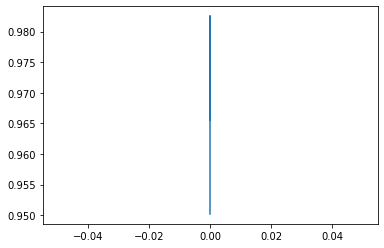

In [ ]:
class Args:
  batch_size=256;
  test_batch_size=1000;
  epochs=15
  n_runs=1
  lr=0.25 # lr SGD
  sigma=1.3
  max_per_sample_grad_norm=1.5
  delta=1e-5
  device='cuda'
  save_model=False
  disable_dp=True
  workers=2
  data_root='/mnist'

args = Args()
device = torch.device(args.device)


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        args.data_root,
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
            ]
        ),
    ),
    batch_size=args.batch_size,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        args.data_root,
        train=False,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
            ]
        ),
    ),
    batch_size=args.test_batch_size,
    shuffle=True,
)
        
tr_loss = np.zeros((args.n_runs,args.epochs))
te_loss = np.zeros((args.n_runs,args.epochs))
te_accu = np.zeros((args.n_runs,args.epochs))
eps = np.zeros((args.n_runs,args.epochs))
for run in range(args.n_runs):
    net = Linear_2L().to(device)

    optimizer = optim.SGD(net.parameters(), lr=args.lr,weight_decay =0.0)
    if not args.disable_dp:
        privacy_engine = PrivacyEngine(
            net,
            batch_size=args.batch_size,
            sample_size=len(train_loader.dataset),
            alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
            noise_multiplier=1.3,
            max_grad_norm=args.max_per_sample_grad_norm,
        )
        privacy_engine.attach(optimizer)
    for epoch in range(1, args.epochs + 1):
        tr_loss[run,epoch-1],eps[run,epoch-1]=train(args, net, device, train_loader, optimizer, epoch)
        te_loss[run,epoch-1],te_accu[run,epoch-1]=test(args, net, device, test_loader)

if args.n_runs > 1:
    print('Training loss: ',np.mean(tr_loss,axis=0),np.std(tr_loss,axis=0))
    print('Testing loss: ',np.mean(te_loss,axis=0),np.std(te_loss,axis=0))
    print('Testing accuracy: ',np.mean(te_accu,axis=0),np.std(te_accu,axis=0))

plt.plot(np.mean(eps,axis=0),np.mean(te_accu,axis=0))

repro_str = (
    f"{net.name()}_{args.lr}_{args.sigma}_"
    f"{args.max_per_sample_grad_norm}_{args.batch_size}_{args.epochs}_MNIST"
)
torch.save([tr_loss,te_loss,te_accu,eps], f"run_results_{repro_str}.pt")


100%|██████████| 10/10 [00:01<00:00,  6.29it/s]


######## ECE: ##############
Local accuracy: 0.9763, predicted confidence 0.9814768038004636, ECE 0.005176803800463703


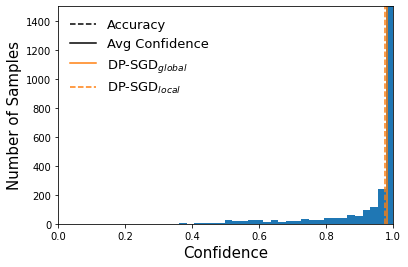

In [ ]:
model_local=net
model_local.eval()
y_local_te=np.empty((0,10))
y_local_te_single=np.array([])
targets_te=np.array([])
prob_local=np.array([])
with torch.no_grad():
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            output = model_local(data)
            y_local_te=np.append(y_local_te,F.softmax(output,dim=1).cpu().detach().numpy(),axis=0)
            y_local_te_single=np.append(y_local_te_single,F.softmax(output,dim=1).argmax(dim=1).cpu().detach().numpy())
            prob_local=np.append(prob_local,np.array([F.softmax(output,dim=1).cpu().detach().numpy()[i,j] for i,j in enumerate(target.cpu().detach().numpy())]))
            targets_te=np.append(targets_te,target.cpu().detach().numpy())


local_acc = np.mean(y_local_te_single == targets_te)
print("######## ECE: ##############")
print(f"Local accuracy: {local_acc}, predicted confidence {np.mean(np.max(y_local_te,axis=1))}, ECE {np.abs(local_acc - np.mean(np.max(y_local_te,axis=1)))}")


plt.plot(0,0,linestyle='dashed',color='black')
plt.plot(0,0,color='black')
plt.plot(0,0,color='#ff7f0e')
plt.plot([np.mean(targets_te==y_local_te_single)]*20,np.linspace(0,1500,20),linestyle='dashed',color='#ff7f0e',label='local Accu')
plt.plot([np.mean(np.max(y_local_te,axis=1))]*20,np.linspace(0,1500,20),color='#ff7f0e')

plt.hist([np.max(y_local_te,axis=1)],bins=30)
plt.ylim(0,1500)
plt.xlim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Number of Samples', fontsize=15)
plt.legend(('Accuracy','Avg Confidence',r'DP-SGD${}_{global}$',r'DP-SGD${}_{local}$'),fontsize=13,loc='upper left',frameon=False)
plt.savefig('Confidence_CIFAR10.pdf',format='pdf')
plt.show()


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


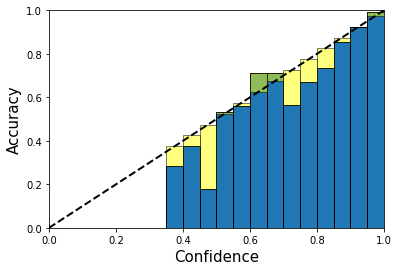

######## MCE: ##############
Local MCE: 0.29852941176470593


In [ ]:
store_local=[]
templ=np.max(y_local_te,axis=1)
dr=0.05
for ratio in np.arange(0,1,dr):
    index=(templ>ratio)*(templ<ratio+dr)
    store_local.append(np.mean(y_local_te_single[index]==targets_te[index]))

# some has nan, replace with 0
store_local=np.array(store_local)
store_local[np.isnan(store_local)]=0
#%%
xaxis=np.arange(0,1,dr)+dr/2
plt.bar(xaxis[store_local!=0],store_local[store_local!=0],width=dr, edgecolor="black")
plt.bar(xaxis[store_local!=0],xaxis[store_local!=0]-store_local[store_local!=0],bottom=store_local[store_local!=0],width=dr, edgecolor="black",color='yellow',alpha=0.5)
plt.bar(10,10,bottom=store_local,width=dr, edgecolor="black",color='green',alpha=0.5)
plt.plot([0,1],[0,1],color='black',linewidth=2,linestyle='dashed')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
#plt.legend(('Perfect calibration','Accuracy','Over-confidence','Under-confidence'),fontsize=13,frameon=0)
plt.savefig('Confidence_CIFAR10_detail_LOCAL.pdf',format='pdf')
plt.show()
#%%
print("######## MCE: ##############")
print(f"Local MCE: {np.max(np.abs(xaxis[store_local!=0]-store_local[store_local!=0]))}")


# ndpsgd + cnn + wd = 0

Train Epoch: 1 	 Loss: 1.090641

Test set: Average loss: 0.0242, Accuracy: 9518/10000 (95.1800%)

Train Epoch: 2 	 Loss: 0.117897

Test set: Average loss: 0.0194, Accuracy: 9606/10000 (96.0600%)

Train Epoch: 3 	 Loss: 0.080468

Test set: Average loss: 0.0223, Accuracy: 9567/10000 (95.6700%)

Train Epoch: 4 	 Loss: 0.060782

Test set: Average loss: 0.0080, Accuracy: 9852/10000 (98.5200%)

Train Epoch: 5 	 Loss: 0.051268

Test set: Average loss: 0.0075, Accuracy: 9857/10000 (98.5700%)

Train Epoch: 6 	 Loss: 0.045990

Test set: Average loss: 0.0081, Accuracy: 9845/10000 (98.4500%)

Train Epoch: 7 	 Loss: 0.038956

Test set: Average loss: 0.0063, Accuracy: 9875/10000 (98.7500%)

Train Epoch: 8 	 Loss: 0.038857

Test set: Average loss: 0.0076, Accuracy: 9861/10000 (98.6100%)

Train Epoch: 9 	 Loss: 0.032556

Test set: Average loss: 0.0066, Accuracy: 9872/10000 (98.7200%)

Train Epoch: 10 	 Loss: 0.031109

Test set: Average loss: 0.0123, Accuracy: 9772/10000 (97.7200%)

Train Epoch: 11 	 L

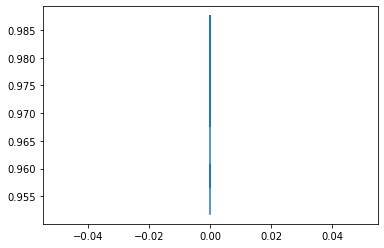

In [ ]:
class Args:
  batch_size=256;
  test_batch_size=1000;
  epochs=15
  n_runs=1
  lr=0.25 # lr SGD
  sigma=1.3
  max_per_sample_grad_norm=1.5
  delta=1e-5
  device='cuda'
  save_model=False
  disable_dp=True
  workers=2
  data_root='/mnist'

args = Args()
device = torch.device(args.device)


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        args.data_root,
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
            ]
        ),
    ),
    batch_size=args.batch_size,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        args.data_root,
        train=False,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
            ]
        ),
    ),
    batch_size=args.test_batch_size,
    shuffle=True,
)
        
tr_loss = np.zeros((args.n_runs,args.epochs))
te_loss = np.zeros((args.n_runs,args.epochs))
te_accu = np.zeros((args.n_runs,args.epochs))
eps = np.zeros((args.n_runs,args.epochs))
for run in range(args.n_runs):
    net = SampleConvNet().to(device)

    optimizer = optim.SGD(net.parameters(), lr=args.lr,weight_decay =0.0)
    if not args.disable_dp:
        privacy_engine = PrivacyEngine(
            net,
            batch_size=args.batch_size,
            sample_size=len(train_loader.dataset),
            alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
            noise_multiplier=1.3,
            max_grad_norm=args.max_per_sample_grad_norm,
        )
        privacy_engine.attach(optimizer)
    for epoch in range(1, args.epochs + 1):
        tr_loss[run,epoch-1],eps[run,epoch-1]=train(args, net, device, train_loader, optimizer, epoch)
        te_loss[run,epoch-1],te_accu[run,epoch-1]=test(args, net, device, test_loader)

if args.n_runs > 1:
    print('Training loss: ',np.mean(tr_loss,axis=0),np.std(tr_loss,axis=0))
    print('Testing loss: ',np.mean(te_loss,axis=0),np.std(te_loss,axis=0))
    print('Testing accuracy: ',np.mean(te_accu,axis=0),np.std(te_accu,axis=0))

plt.plot(np.mean(eps,axis=0),np.mean(te_accu,axis=0))

repro_str = (
    f"{net.name()}_{args.lr}_{args.sigma}_"
    f"{args.max_per_sample_grad_norm}_{args.batch_size}_{args.epochs}_MNIST"
)
torch.save([tr_loss,te_loss,te_accu,eps], f"run_results_{repro_str}.pt")


100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


######## ECE: ##############
Local accuracy: 0.9677, predicted confidence 0.9822251159101725, ECE 0.01452511591017247


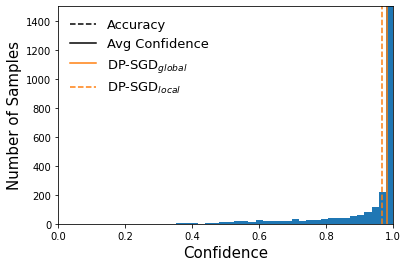

In [ ]:
model_local=net
model_local.eval()
y_local_te=np.empty((0,10))
y_local_te_single=np.array([])
targets_te=np.array([])
prob_local=np.array([])
with torch.no_grad():
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            output = model_local(data)
            y_local_te=np.append(y_local_te,F.softmax(output,dim=1).cpu().detach().numpy(),axis=0)
            y_local_te_single=np.append(y_local_te_single,F.softmax(output,dim=1).argmax(dim=1).cpu().detach().numpy())
            prob_local=np.append(prob_local,np.array([F.softmax(output,dim=1).cpu().detach().numpy()[i,j] for i,j in enumerate(target.cpu().detach().numpy())]))
            targets_te=np.append(targets_te,target.cpu().detach().numpy())


local_acc = np.mean(y_local_te_single == targets_te)
print("######## ECE: ##############")
print(f"Local accuracy: {local_acc}, predicted confidence {np.mean(np.max(y_local_te,axis=1))}, ECE {np.abs(local_acc - np.mean(np.max(y_local_te,axis=1)))}")


plt.plot(0,0,linestyle='dashed',color='black')
plt.plot(0,0,color='black')
plt.plot(0,0,color='#ff7f0e')
plt.plot([np.mean(targets_te==y_local_te_single)]*20,np.linspace(0,1500,20),linestyle='dashed',color='#ff7f0e',label='local Accu')
plt.plot([np.mean(np.max(y_local_te,axis=1))]*20,np.linspace(0,1500,20),color='#ff7f0e')

plt.hist([np.max(y_local_te,axis=1)],bins=30)
plt.ylim(0,1500)
plt.xlim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Number of Samples', fontsize=15)
plt.legend(('Accuracy','Avg Confidence',r'DP-SGD${}_{global}$',r'DP-SGD${}_{local}$'),fontsize=13,loc='upper left',frameon=False)
plt.savefig('Confidence_CIFAR10.pdf',format='pdf')
plt.show()


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


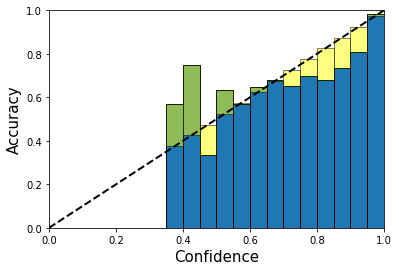

######## MCE: ##############
Local MCE: 0.32499999999999996


In [ ]:
store_local=[]
templ=np.max(y_local_te,axis=1)
dr=0.05
for ratio in np.arange(0,1,dr):
    index=(templ>ratio)*(templ<ratio+dr)
    store_local.append(np.mean(y_local_te_single[index]==targets_te[index]))

# some has nan, replace with 0
store_local=np.array(store_local)
store_local[np.isnan(store_local)]=0
#%%
xaxis=np.arange(0,1,dr)+dr/2
plt.bar(xaxis[store_local!=0],store_local[store_local!=0],width=dr, edgecolor="black")
plt.bar(xaxis[store_local!=0],xaxis[store_local!=0]-store_local[store_local!=0],bottom=store_local[store_local!=0],width=dr, edgecolor="black",color='yellow',alpha=0.5)
plt.bar(10,10,bottom=store_local,width=dr, edgecolor="black",color='green',alpha=0.5)
plt.plot([0,1],[0,1],color='black',linewidth=2,linestyle='dashed')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
#plt.legend(('Perfect calibration','Accuracy','Over-confidence','Under-confidence'),fontsize=13,frameon=0)
plt.savefig('Confidence_CIFAR10_detail_LOCAL.pdf',format='pdf')
plt.show()
#%%
print("######## MCE: ##############")
print(f"Local MCE: {np.max(np.abs(xaxis[store_local!=0]-store_local[store_local!=0]))}")


/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:518: UserWarning: The sample rate will be defined from ``batch_size`` and ``sample_size``.The returned privacy budget will be incorrect.
  "The sample rate will be defined from ``batch_size`` and ``sample_size``."
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:195: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  wa

Train Epoch: 1 	Loss: 1.015334 (ε = 0.72, δ = 1e-05) for α = 18.0

Test set: Average loss: 0.0911, Accuracy: 8488/10000 (84.8800%)

Train Epoch: 2 	Loss: 0.492624 (ε = 0.76, δ = 1e-05) for α = 18.0

Test set: Average loss: 0.0843, Accuracy: 8943/10000 (89.4300%)

Train Epoch: 3 	Loss: 0.429593 (ε = 0.80, δ = 1e-05) for α = 18.0

Test set: Average loss: 0.0705, Accuracy: 9162/10000 (91.6200%)

Train Epoch: 4 	Loss: 0.381522 (ε = 0.84, δ = 1e-05) for α = 18.0

Test set: Average loss: 0.0653, Accuracy: 9240/10000 (92.4000%)

Train Epoch: 5 	Loss: 0.375281 (ε = 0.88, δ = 1e-05) for α = 17.0

Test set: Average loss: 0.0681, Accuracy: 9245/10000 (92.4500%)

Train Epoch: 6 	Loss: 0.383160 (ε = 0.91, δ = 1e-05) for α = 17.0

Test set: Average loss: 0.0693, Accuracy: 9295/10000 (92.9500%)

Train Epoch: 7 	Loss: 0.368236 (ε = 0.94, δ = 1e-05) for α = 17.0

Test set: Average loss: 0.0607, Accuracy: 9365/10000 (93.6500%)

Train Epoch: 8 	Loss: 0.365283 (ε = 0.97, δ = 1e-05) for α = 17.0

Test set:

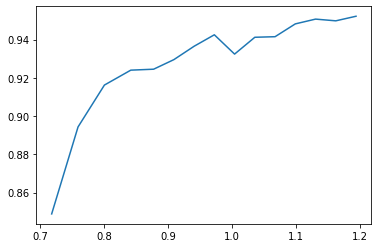

In [ ]:
class Args:
  batch_size=256;
  test_batch_size=1000;
  epochs=15
  n_runs=1
  lr=0.25 # lr SGD
  sigma=1.3
  max_per_sample_grad_norm=1.5
  delta=1e-5
  device='cuda'
  save_model=False
  disable_dp=False
  workers=2
  data_root='/mnist'

args = Args()
device = torch.device(args.device)


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        args.data_root,
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
            ]
        ),
    ),
    batch_size=args.batch_size,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        args.data_root,
        train=False,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
            ]
        ),
    ),
    batch_size=args.test_batch_size,
    shuffle=True,
)
        
tr_loss = np.zeros((args.n_runs,args.epochs))
te_loss = np.zeros((args.n_runs,args.epochs))
te_accu = np.zeros((args.n_runs,args.epochs))
eps = np.zeros((args.n_runs,args.epochs))
for run in range(args.n_runs):
    net = SampleConvNet().to(device)

    optimizer = optim.SGD(net.parameters(), lr=args.lr,weight_decay =0.0)
    if not args.disable_dp:
        privacy_engine = PrivacyEngine(
            net,
            batch_size=args.batch_size,
            sample_size=len(train_loader.dataset),
            alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
            noise_multiplier=1.3,
            max_grad_norm=args.max_per_sample_grad_norm,
        )
        privacy_engine.attach(optimizer)
    for epoch in range(1, args.epochs + 1):
        tr_loss[run,epoch-1],eps[run,epoch-1]=train(args, net, device, train_loader, optimizer, epoch)
        te_loss[run,epoch-1],te_accu[run,epoch-1]=test(args, net, device, test_loader)

if args.n_runs > 1:
    print('Training loss: ',np.mean(tr_loss,axis=0),np.std(tr_loss,axis=0))
    print('Testing loss: ',np.mean(te_loss,axis=0),np.std(te_loss,axis=0))
    print('Testing accuracy: ',np.mean(te_accu,axis=0),np.std(te_accu,axis=0))

plt.plot(np.mean(eps,axis=0),np.mean(te_accu,axis=0))

repro_str = (
    f"{net.name()}_{args.lr}_{args.sigma}_"
    f"{args.max_per_sample_grad_norm}_{args.batch_size}_{args.epochs}_MNIST"
)
torch.save([tr_loss,te_loss,te_accu,eps], f"run_results_{repro_str}.pt")


100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


######## ECE: ##############
Local accuracy: 0.9522, predicted confidence 0.9890677695304155, ECE 0.036867769530415484


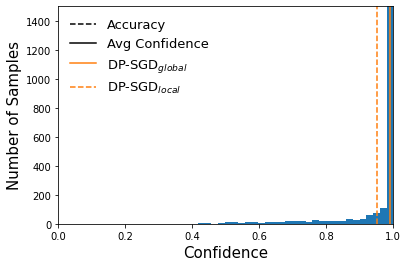

In [ ]:
model_local=net
model_local.eval()
y_local_te=np.empty((0,10))
y_local_te_single=np.array([])
targets_te=np.array([])
prob_local=np.array([])
with torch.no_grad():
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            output = model_local(data)
            y_local_te=np.append(y_local_te,F.softmax(output,dim=1).cpu().detach().numpy(),axis=0)
            y_local_te_single=np.append(y_local_te_single,F.softmax(output,dim=1).argmax(dim=1).cpu().detach().numpy())
            prob_local=np.append(prob_local,np.array([F.softmax(output,dim=1).cpu().detach().numpy()[i,j] for i,j in enumerate(target.cpu().detach().numpy())]))
            targets_te=np.append(targets_te,target.cpu().detach().numpy())


local_acc = np.mean(y_local_te_single == targets_te)
print("######## ECE: ##############")
print(f"Local accuracy: {local_acc}, predicted confidence {np.mean(np.max(y_local_te,axis=1))}, ECE {np.abs(local_acc - np.mean(np.max(y_local_te,axis=1)))}")


plt.plot(0,0,linestyle='dashed',color='black')
plt.plot(0,0,color='black')
plt.plot(0,0,color='#ff7f0e')
plt.plot([np.mean(targets_te==y_local_te_single)]*20,np.linspace(0,1500,20),linestyle='dashed',color='#ff7f0e',label='local Accu')
plt.plot([np.mean(np.max(y_local_te,axis=1))]*20,np.linspace(0,1500,20),color='#ff7f0e')

plt.hist([np.max(y_local_te,axis=1)],bins=30)
plt.ylim(0,1500)
plt.xlim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Number of Samples', fontsize=15)
plt.legend(('Accuracy','Avg Confidence',r'DP-SGD${}_{global}$',r'DP-SGD${}_{local}$'),fontsize=13,loc='upper left',frameon=False)
plt.savefig('Confidence_CIFAR10.pdf',format='pdf')
plt.show()


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


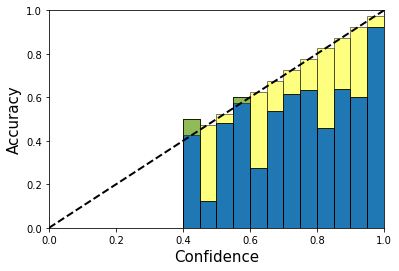

######## MCE: ##############
Local MCE: 0.36500000000000005


In [ ]:
store_local=[]
templ=np.max(y_local_te,axis=1)
dr=0.05
for ratio in np.arange(0,1,dr):
    index=(templ>ratio)*(templ<ratio+dr)
    store_local.append(np.mean(y_local_te_single[index]==targets_te[index]))

# some has nan, replace with 0
store_local=np.array(store_local)
store_local[np.isnan(store_local)]=0
#%%
xaxis=np.arange(0,1,dr)+dr/2
plt.bar(xaxis[store_local!=0],store_local[store_local!=0],width=dr, edgecolor="black")
plt.bar(xaxis[store_local!=0],xaxis[store_local!=0]-store_local[store_local!=0],bottom=store_local[store_local!=0],width=dr, edgecolor="black",color='yellow',alpha=0.5)
plt.bar(10,10,bottom=store_local,width=dr, edgecolor="black",color='green',alpha=0.5)
plt.plot([0,1],[0,1],color='black',linewidth=2,linestyle='dashed')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
#plt.legend(('Perfect calibration','Accuracy','Over-confidence','Under-confidence'),fontsize=13,frameon=0)
plt.savefig('Confidence_CIFAR10_detail_LOCAL.pdf',format='pdf')
plt.show()
#%%
print("######## MCE: ##############")
print(f"Local MCE: {np.max(np.abs(xaxis[store_local!=0]-store_local[store_local!=0]))}")


# dpsgd+2l+wd=1.0 acc = 0.6

/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:518: UserWarning: The sample rate will be defined from ``batch_size`` and ``sample_size``.The returned privacy budget will be incorrect.
  "The sample rate will be defined from ``batch_size`` and ``sample_size``."
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:195: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  wa

Train Epoch: 1 	Loss: 1.769854 (ε = 0.72, δ = 1e-05) for α = 18.0

Test set: Average loss: 0.2831, Accuracy: 5929/10000 (59.2900%)

Train Epoch: 2 	Loss: 1.659416 (ε = 0.76, δ = 1e-05) for α = 18.0

Test set: Average loss: 0.2789, Accuracy: 5578/10000 (55.7800%)

Train Epoch: 3 	Loss: 1.656963 (ε = 0.80, δ = 1e-05) for α = 18.0

Test set: Average loss: 0.2794, Accuracy: 5824/10000 (58.2400%)

Train Epoch: 4 	Loss: 1.657102 (ε = 0.84, δ = 1e-05) for α = 18.0

Test set: Average loss: 0.2793, Accuracy: 6011/10000 (60.1100%)

Train Epoch: 5 	Loss: 1.656803 (ε = 0.88, δ = 1e-05) for α = 17.0

Test set: Average loss: 0.2780, Accuracy: 5679/10000 (56.7900%)

Train Epoch: 6 	Loss: 1.658260 (ε = 0.91, δ = 1e-05) for α = 17.0

Test set: Average loss: 0.2779, Accuracy: 5281/10000 (52.8100%)

Train Epoch: 7 	Loss: 1.650106 (ε = 0.94, δ = 1e-05) for α = 17.0

Test set: Average loss: 0.2773, Accuracy: 6084/10000 (60.8400%)

Train Epoch: 8 	Loss: 1.656751 (ε = 0.97, δ = 1e-05) for α = 17.0

Test set:

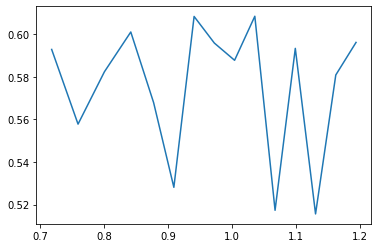

In [ ]:
class Args:
  batch_size=256;
  test_batch_size=1000;
  epochs=15
  n_runs=1
  lr=0.25 # lr SGD
  sigma=1.3
  max_per_sample_grad_norm=1.5
  delta=1e-5
  device='cuda'
  save_model=False
  disable_dp=False
  workers=2
  data_root='/mnist'

args = Args()
device = torch.device(args.device)


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        args.data_root,
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
            ]
        ),
    ),
    batch_size=args.batch_size,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        args.data_root,
        train=False,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
            ]
        ),
    ),
    batch_size=args.test_batch_size,
    shuffle=True,
)
        
tr_loss = np.zeros((args.n_runs,args.epochs))
te_loss = np.zeros((args.n_runs,args.epochs))
te_accu = np.zeros((args.n_runs,args.epochs))
eps = np.zeros((args.n_runs,args.epochs))
for run in range(args.n_runs):
    net = Linear_2L().to(device)

    optimizer = optim.SGD(net.parameters(), lr=args.lr,weight_decay =0.1)
    if not args.disable_dp:
        privacy_engine = PrivacyEngine(
            net,
            batch_size=args.batch_size,
            sample_size=len(train_loader.dataset),
            alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
            noise_multiplier=1.3,
            max_grad_norm=args.max_per_sample_grad_norm,
        )
        privacy_engine.attach(optimizer)
    for epoch in range(1, args.epochs + 1):
        tr_loss[run,epoch-1],eps[run,epoch-1]=train(args, net, device, train_loader, optimizer, epoch)
        te_loss[run,epoch-1],te_accu[run,epoch-1]=test(args, net, device, test_loader)

if args.n_runs > 1:
    print('Training loss: ',np.mean(tr_loss,axis=0),np.std(tr_loss,axis=0))
    print('Testing loss: ',np.mean(te_loss,axis=0),np.std(te_loss,axis=0))
    print('Testing accuracy: ',np.mean(te_accu,axis=0),np.std(te_accu,axis=0))

plt.plot(np.mean(eps,axis=0),np.mean(te_accu,axis=0))

repro_str = (
    f"{net.name()}_{args.lr}_{args.sigma}_"
    f"{args.max_per_sample_grad_norm}_{args.batch_size}_{args.epochs}_MNIST"
)
torch.save([tr_loss,te_loss,te_accu,eps], f"run_results_{repro_str}.pt")


# dpsgd + 2l + wd=0.01

/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:518: UserWarning: The sample rate will be defined from ``batch_size`` and ``sample_size``.The returned privacy budget will be incorrect.
  "The sample rate will be defined from ``batch_size`` and ``sample_size``."
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:195: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  wa

Train Epoch: 1 	Loss: 0.776995 (ε = 0.72, δ = 1e-05) for α = 18.0

Test set: Average loss: 0.0705, Accuracy: 8708/10000 (87.0800%)

Train Epoch: 2 	Loss: 0.426835 (ε = 0.76, δ = 1e-05) for α = 18.0

Test set: Average loss: 0.0649, Accuracy: 8852/10000 (88.5200%)

Train Epoch: 3 	Loss: 0.413437 (ε = 0.80, δ = 1e-05) for α = 18.0

Test set: Average loss: 0.0656, Accuracy: 8820/10000 (88.2000%)

Train Epoch: 4 	Loss: 0.408618 (ε = 0.84, δ = 1e-05) for α = 18.0

Test set: Average loss: 0.0630, Accuracy: 8865/10000 (88.6500%)

Train Epoch: 5 	Loss: 0.410184 (ε = 0.88, δ = 1e-05) for α = 17.0

Test set: Average loss: 0.0652, Accuracy: 8792/10000 (87.9200%)

Train Epoch: 6 	Loss: 0.408282 (ε = 0.91, δ = 1e-05) for α = 17.0

Test set: Average loss: 0.0665, Accuracy: 8804/10000 (88.0400%)

Train Epoch: 7 	Loss: 0.405568 (ε = 0.94, δ = 1e-05) for α = 17.0

Test set: Average loss: 0.0621, Accuracy: 8866/10000 (88.6600%)

Train Epoch: 8 	Loss: 0.405068 (ε = 0.97, δ = 1e-05) for α = 17.0

Test set:

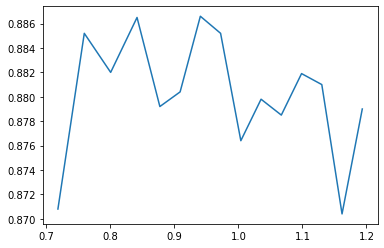

In [ ]:
class Args:
  batch_size=256;
  test_batch_size=1000;
  epochs=15
  n_runs=1
  lr=0.25 # lr SGD
  sigma=1.3
  max_per_sample_grad_norm=1.5
  delta=1e-5
  device='cuda'
  save_model=False
  disable_dp=False
  workers=2
  data_root='/mnist'

args = Args()
device = torch.device(args.device)


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        args.data_root,
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
            ]
        ),
    ),
    batch_size=args.batch_size,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        args.data_root,
        train=False,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
            ]
        ),
    ),
    batch_size=args.test_batch_size,
    shuffle=True,
)
        
tr_loss = np.zeros((args.n_runs,args.epochs))
te_loss = np.zeros((args.n_runs,args.epochs))
te_accu = np.zeros((args.n_runs,args.epochs))
eps = np.zeros((args.n_runs,args.epochs))
for run in range(args.n_runs):
    net = Linear_2L().to(device)

    optimizer = optim.SGD(net.parameters(), lr=args.lr,weight_decay =0.01)
    if not args.disable_dp:
        privacy_engine = PrivacyEngine(
            net,
            batch_size=args.batch_size,
            sample_size=len(train_loader.dataset),
            alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
            noise_multiplier=1.3,
            max_grad_norm=args.max_per_sample_grad_norm,
        )
        privacy_engine.attach(optimizer)
    for epoch in range(1, args.epochs + 1):
        tr_loss[run,epoch-1],eps[run,epoch-1]=train(args, net, device, train_loader, optimizer, epoch)
        te_loss[run,epoch-1],te_accu[run,epoch-1]=test(args, net, device, test_loader)

if args.n_runs > 1:
    print('Training loss: ',np.mean(tr_loss,axis=0),np.std(tr_loss,axis=0))
    print('Testing loss: ',np.mean(te_loss,axis=0),np.std(te_loss,axis=0))
    print('Testing accuracy: ',np.mean(te_accu,axis=0),np.std(te_accu,axis=0))

plt.plot(np.mean(eps,axis=0),np.mean(te_accu,axis=0))

repro_str = (
    f"{net.name()}_{args.lr}_{args.sigma}_"
    f"{args.max_per_sample_grad_norm}_{args.batch_size}_{args.epochs}_MNIST"
)
torch.save([tr_loss,te_loss,te_accu,eps], f"run_results_{repro_str}.pt")


100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


######## ECE: ##############
Local accuracy: 0.9763, predicted confidence 0.9814768038004636, ECE 0.005176803800463703


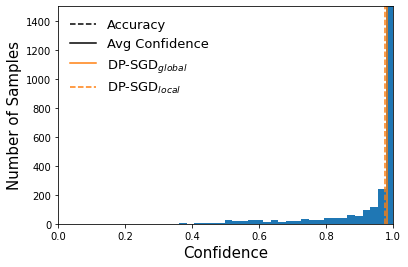

In [ ]:
model_local=net
model_local.eval()
y_local_te=np.empty((0,10))
y_local_te_single=np.array([])
targets_te=np.array([])
prob_local=np.array([])
with torch.no_grad():
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            output = model_local(data)
            y_local_te=np.append(y_local_te,F.softmax(output,dim=1).cpu().detach().numpy(),axis=0)
            y_local_te_single=np.append(y_local_te_single,F.softmax(output,dim=1).argmax(dim=1).cpu().detach().numpy())
            prob_local=np.append(prob_local,np.array([F.softmax(output,dim=1).cpu().detach().numpy()[i,j] for i,j in enumerate(target.cpu().detach().numpy())]))
            targets_te=np.append(targets_te,target.cpu().detach().numpy())


local_acc = np.mean(y_local_te_single == targets_te)
print("######## ECE: ##############")
print(f"Local accuracy: {local_acc}, predicted confidence {np.mean(np.max(y_local_te,axis=1))}, ECE {np.abs(local_acc - np.mean(np.max(y_local_te,axis=1)))}")


plt.plot(0,0,linestyle='dashed',color='black')
plt.plot(0,0,color='black')
plt.plot(0,0,color='#ff7f0e')
plt.plot([np.mean(targets_te==y_local_te_single)]*20,np.linspace(0,1500,20),linestyle='dashed',color='#ff7f0e',label='local Accu')
plt.plot([np.mean(np.max(y_local_te,axis=1))]*20,np.linspace(0,1500,20),color='#ff7f0e')

plt.hist([np.max(y_local_te,axis=1)],bins=30)
plt.ylim(0,1500)
plt.xlim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Number of Samples', fontsize=15)
plt.legend(('Accuracy','Avg Confidence',r'DP-SGD${}_{global}$',r'DP-SGD${}_{local}$'),fontsize=13,loc='upper left',frameon=False)
plt.savefig('Confidence_CIFAR10.pdf',format='pdf')
plt.show()


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


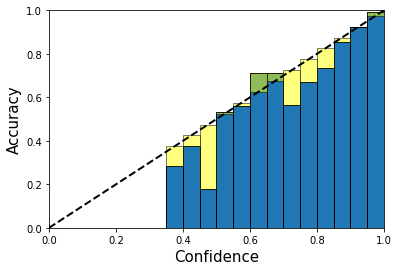

######## MCE: ##############
Local MCE: 0.29852941176470593


In [ ]:
store_local=[]
templ=np.max(y_local_te,axis=1)
dr=0.05
for ratio in np.arange(0,1,dr):
    index=(templ>ratio)*(templ<ratio+dr)
    store_local.append(np.mean(y_local_te_single[index]==targets_te[index]))

# some has nan, replace with 0
store_local=np.array(store_local)
store_local[np.isnan(store_local)]=0
#%%
xaxis=np.arange(0,1,dr)+dr/2
plt.bar(xaxis[store_local!=0],store_local[store_local!=0],width=dr, edgecolor="black")
plt.bar(xaxis[store_local!=0],xaxis[store_local!=0]-store_local[store_local!=0],bottom=store_local[store_local!=0],width=dr, edgecolor="black",color='yellow',alpha=0.5)
plt.bar(10,10,bottom=store_local,width=dr, edgecolor="black",color='green',alpha=0.5)
plt.plot([0,1],[0,1],color='black',linewidth=2,linestyle='dashed')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
#plt.legend(('Perfect calibration','Accuracy','Over-confidence','Under-confidence'),fontsize=13,frameon=0)
plt.savefig('Confidence_CIFAR10_detail_LOCAL.pdf',format='pdf')
plt.show()
#%%
print("######## MCE: ##############")
print(f"Local MCE: {np.max(np.abs(xaxis[store_local!=0]-store_local[store_local!=0]))}")


# dpsgd + cnn + wd=0.01


Extracting /mnist/MNIST/raw/train-images-idx3-ubyte.gz to /mnist/MNIST/raw




Extracting /mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /mnist/MNIST/raw




Extracting /mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /mnist/MNIST/raw




Extracting /mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /mnist/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:518: UserWarning: The sample rate will be defined from ``batch_size`` and ``sample_size``.The returned privacy budget will be incorrect.
  "The sample rate will be defined from ``batch_size`` and ``sample_size``."
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:195: UserWarning: Secure RNG turned off. This is perfectly f

Train Epoch: 1 	Loss: 0.915374 (ε = 0.72, δ = 1e-05) for α = 18.0

Test set: Average loss: 0.0790, Accuracy: 8451/10000 (84.5100%)

Train Epoch: 2 	Loss: 0.361223 (ε = 0.76, δ = 1e-05) for α = 18.0

Test set: Average loss: 0.0681, Accuracy: 8755/10000 (87.5500%)

Train Epoch: 3 	Loss: 0.300761 (ε = 0.80, δ = 1e-05) for α = 18.0

Test set: Average loss: 0.0440, Accuracy: 9226/10000 (92.2600%)

Train Epoch: 4 	Loss: 0.279648 (ε = 0.84, δ = 1e-05) for α = 18.0

Test set: Average loss: 0.0449, Accuracy: 9173/10000 (91.7300%)

Train Epoch: 5 	Loss: 0.269019 (ε = 0.88, δ = 1e-05) for α = 17.0

Test set: Average loss: 0.0417, Accuracy: 9223/10000 (92.2300%)

Train Epoch: 6 	Loss: 0.269960 (ε = 0.91, δ = 1e-05) for α = 17.0

Test set: Average loss: 0.0388, Accuracy: 9300/10000 (93.0000%)

Train Epoch: 7 	Loss: 0.264955 (ε = 0.94, δ = 1e-05) for α = 17.0

Test set: Average loss: 0.0505, Accuracy: 9103/10000 (91.0300%)

Train Epoch: 8 	Loss: 0.267058 (ε = 0.97, δ = 1e-05) for α = 17.0

Test set:

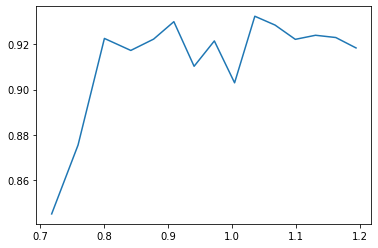

In [ ]:
class Args:
  batch_size=256;
  test_batch_size=1000;
  epochs=15
  n_runs=1
  lr=0.25 # lr SGD
  sigma=1.3
  max_per_sample_grad_norm=1.5
  delta=1e-5
  device='cuda'
  save_model=False
  disable_dp=False
  workers=2
  data_root='/mnist'

args = Args()
device = torch.device(args.device)


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        args.data_root,
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
            ]
        ),
    ),
    batch_size=args.batch_size,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        args.data_root,
        train=False,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
            ]
        ),
    ),
    batch_size=args.test_batch_size,
    shuffle=True,
)
        
tr_loss = np.zeros((args.n_runs,args.epochs))
te_loss = np.zeros((args.n_runs,args.epochs))
te_accu = np.zeros((args.n_runs,args.epochs))
eps = np.zeros((args.n_runs,args.epochs))
for run in range(args.n_runs):
    net = SampleConvNet().to(device)

    optimizer = optim.SGD(net.parameters(), lr=args.lr,weight_decay =0.01)
    if not args.disable_dp:
        privacy_engine = PrivacyEngine(
            net,
            batch_size=args.batch_size,
            sample_size=len(train_loader.dataset),
            alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
            noise_multiplier=1.3,
            max_grad_norm=args.max_per_sample_grad_norm,
        )
        privacy_engine.attach(optimizer)
    for epoch in range(1, args.epochs + 1):
        tr_loss[run,epoch-1],eps[run,epoch-1]=train(args, net, device, train_loader, optimizer, epoch)
        te_loss[run,epoch-1],te_accu[run,epoch-1]=test(args, net, device, test_loader)

if args.n_runs > 1:
    print('Training loss: ',np.mean(tr_loss,axis=0),np.std(tr_loss,axis=0))
    print('Testing loss: ',np.mean(te_loss,axis=0),np.std(te_loss,axis=0))
    print('Testing accuracy: ',np.mean(te_accu,axis=0),np.std(te_accu,axis=0))

plt.plot(np.mean(eps,axis=0),np.mean(te_accu,axis=0))

repro_str = (
    f"{net.name()}_{args.lr}_{args.sigma}_"
    f"{args.max_per_sample_grad_norm}_{args.batch_size}_{args.epochs}_MNIST"
)
torch.save([tr_loss,te_loss,te_accu,eps], f"run_results_{repro_str}.pt")


100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


######## ECE: ##############
Local accuracy: 0.9184, predicted confidence 0.9243876291424036, ECE 0.005987629142403583


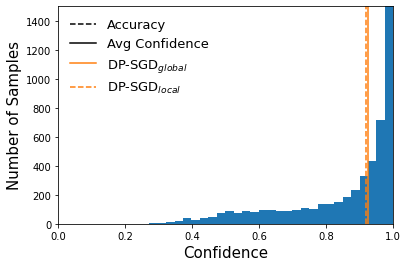

In [ ]:
model_local=net
model_local.eval()
y_local_te=np.empty((0,10))
y_local_te_single=np.array([])
targets_te=np.array([])
prob_local=np.array([])
with torch.no_grad():
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            output = model_local(data)
            y_local_te=np.append(y_local_te,F.softmax(output,dim=1).cpu().detach().numpy(),axis=0)
            y_local_te_single=np.append(y_local_te_single,F.softmax(output,dim=1).argmax(dim=1).cpu().detach().numpy())
            prob_local=np.append(prob_local,np.array([F.softmax(output,dim=1).cpu().detach().numpy()[i,j] for i,j in enumerate(target.cpu().detach().numpy())]))
            targets_te=np.append(targets_te,target.cpu().detach().numpy())


local_acc = np.mean(y_local_te_single == targets_te)
print("######## ECE: ##############")
print(f"Local accuracy: {local_acc}, predicted confidence {np.mean(np.max(y_local_te,axis=1))}, ECE {np.abs(local_acc - np.mean(np.max(y_local_te,axis=1)))}")


plt.plot(0,0,linestyle='dashed',color='black')
plt.plot(0,0,color='black')
plt.plot(0,0,color='#ff7f0e')
plt.plot([np.mean(targets_te==y_local_te_single)]*20,np.linspace(0,1500,20),linestyle='dashed',color='#ff7f0e',label='local Accu')
plt.plot([np.mean(np.max(y_local_te,axis=1))]*20,np.linspace(0,1500,20),color='#ff7f0e')

plt.hist([np.max(y_local_te,axis=1)],bins=30)
plt.ylim(0,1500)
plt.xlim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Number of Samples', fontsize=15)
plt.legend(('Accuracy','Avg Confidence',r'DP-SGD${}_{global}$',r'DP-SGD${}_{local}$'),fontsize=13,loc='upper left',frameon=False)
plt.savefig('Confidence_CIFAR10.pdf',format='pdf')
plt.show()


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


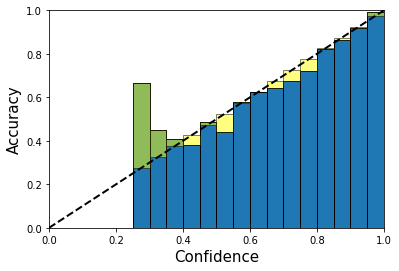

######## MCE: ##############
Local MCE: 0.3916666666666666


In [ ]:
store_local=[]
templ=np.max(y_local_te,axis=1)
dr=0.05
for ratio in np.arange(0,1,dr):
    index=(templ>ratio)*(templ<ratio+dr)
    store_local.append(np.mean(y_local_te_single[index]==targets_te[index]))

# some has nan, replace with 0
store_local=np.array(store_local)
store_local[np.isnan(store_local)]=0
#%%
xaxis=np.arange(0,1,dr)+dr/2
plt.bar(xaxis[store_local!=0],store_local[store_local!=0],width=dr, edgecolor="black")
plt.bar(xaxis[store_local!=0],xaxis[store_local!=0]-store_local[store_local!=0],bottom=store_local[store_local!=0],width=dr, edgecolor="black",color='yellow',alpha=0.5)
plt.bar(10,10,bottom=store_local,width=dr, edgecolor="black",color='green',alpha=0.5)
plt.plot([0,1],[0,1],color='black',linewidth=2,linestyle='dashed')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
#plt.legend(('Perfect calibration','Accuracy','Over-confidence','Under-confidence'),fontsize=13,frameon=0)
plt.savefig('Confidence_CIFAR10_detail_LOCAL.pdf',format='pdf')
plt.show()
#%%
print("######## MCE: ##############")
print(f"Local MCE: {np.max(np.abs(xaxis[store_local!=0]-store_local[store_local!=0]))}")


# ndpsgd + cnn + wd=0.01

Train Epoch: 1 	 Loss: 1.033231

Test set: Average loss: 0.0388, Accuracy: 9238/10000 (92.3800%)

Train Epoch: 2 	 Loss: 0.591669

Test set: Average loss: 0.0472, Accuracy: 9090/10000 (90.9000%)

Train Epoch: 3 	 Loss: 0.193496

Test set: Average loss: 0.0287, Accuracy: 9435/10000 (94.3500%)

Train Epoch: 4 	 Loss: 0.156779

Test set: Average loss: 0.0180, Accuracy: 9667/10000 (96.6700%)

Train Epoch: 5 	 Loss: 0.418925

Test set: Average loss: 0.0339, Accuracy: 9365/10000 (93.6500%)

Train Epoch: 6 	 Loss: 0.156705

Test set: Average loss: 0.0195, Accuracy: 9636/10000 (96.3600%)

Train Epoch: 7 	 Loss: 0.634463

Test set: Average loss: 0.3138, Accuracy: 3936/10000 (39.3600%)

Train Epoch: 8 	 Loss: 0.522198

Test set: Average loss: 0.0233, Accuracy: 9576/10000 (95.7600%)

Train Epoch: 9 	 Loss: 0.313471

Test set: Average loss: 0.0202, Accuracy: 9624/10000 (96.2400%)

Train Epoch: 10 	 Loss: 0.268737

Test set: Average loss: 0.0247, Accuracy: 9574/10000 (95.7400%)

Train Epoch: 11 	 L

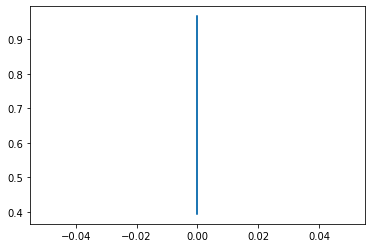

In [ ]:
class Args:
  batch_size=256;
  test_batch_size=1000;
  epochs=15
  n_runs=1
  lr=0.25 # lr SGD
  sigma=1.3
  max_per_sample_grad_norm=1.5
  delta=1e-5
  device='cuda'
  save_model=False
  disable_dp=True
  workers=2
  data_root='/mnist'

args = Args()
device = torch.device(args.device)


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        args.data_root,
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
            ]
        ),
    ),
    batch_size=args.batch_size,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        args.data_root,
        train=False,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
            ]
        ),
    ),
    batch_size=args.test_batch_size,
    shuffle=True,
)
        
tr_loss = np.zeros((args.n_runs,args.epochs))
te_loss = np.zeros((args.n_runs,args.epochs))
te_accu = np.zeros((args.n_runs,args.epochs))
eps = np.zeros((args.n_runs,args.epochs))
for run in range(args.n_runs):
    net = SampleConvNet().to(device)

    optimizer = optim.SGD(net.parameters(), lr=args.lr,weight_decay =0.01)
    if not args.disable_dp:
        privacy_engine = PrivacyEngine(
            net,
            batch_size=args.batch_size,
            sample_size=len(train_loader.dataset),
            alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
            noise_multiplier=1.3,
            max_grad_norm=args.max_per_sample_grad_norm,
        )
        privacy_engine.attach(optimizer)
    for epoch in range(1, args.epochs + 1):
        tr_loss[run,epoch-1],eps[run,epoch-1]=train(args, net, device, train_loader, optimizer, epoch)
        te_loss[run,epoch-1],te_accu[run,epoch-1]=test(args, net, device, test_loader)

if args.n_runs > 1:
    print('Training loss: ',np.mean(tr_loss,axis=0),np.std(tr_loss,axis=0))
    print('Testing loss: ',np.mean(te_loss,axis=0),np.std(te_loss,axis=0))
    print('Testing accuracy: ',np.mean(te_accu,axis=0),np.std(te_accu,axis=0))

plt.plot(np.mean(eps,axis=0),np.mean(te_accu,axis=0))

repro_str = (
    f"{net.name()}_{args.lr}_{args.sigma}_"
    f"{args.max_per_sample_grad_norm}_{args.batch_size}_{args.epochs}_MNIST"
)
torch.save([tr_loss,te_loss,te_accu,eps], f"run_results_{repro_str}.pt")


100%|██████████| 10/10 [00:01<00:00,  6.24it/s]


######## ECE: ##############
Local accuracy: 0.9134, predicted confidence 0.9113617735147477, ECE 0.0020382264852523146


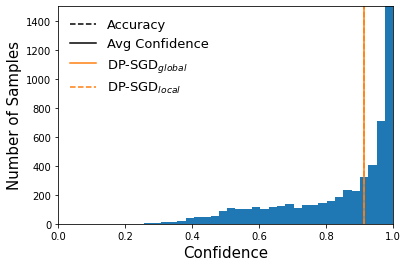

In [ ]:
model_local=net
model_local.eval()
y_local_te=np.empty((0,10))
y_local_te_single=np.array([])
targets_te=np.array([])
prob_local=np.array([])
with torch.no_grad():
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            output = model_local(data)
            y_local_te=np.append(y_local_te,F.softmax(output,dim=1).cpu().detach().numpy(),axis=0)
            y_local_te_single=np.append(y_local_te_single,F.softmax(output,dim=1).argmax(dim=1).cpu().detach().numpy())
            prob_local=np.append(prob_local,np.array([F.softmax(output,dim=1).cpu().detach().numpy()[i,j] for i,j in enumerate(target.cpu().detach().numpy())]))
            targets_te=np.append(targets_te,target.cpu().detach().numpy())


local_acc = np.mean(y_local_te_single == targets_te)
print("######## ECE: ##############")
print(f"Local accuracy: {local_acc}, predicted confidence {np.mean(np.max(y_local_te,axis=1))}, ECE {np.abs(local_acc - np.mean(np.max(y_local_te,axis=1)))}")


plt.plot(0,0,linestyle='dashed',color='black')
plt.plot(0,0,color='black')
plt.plot(0,0,color='#ff7f0e')
plt.plot([np.mean(targets_te==y_local_te_single)]*20,np.linspace(0,1500,20),linestyle='dashed',color='#ff7f0e',label='local Accu')
plt.plot([np.mean(np.max(y_local_te,axis=1))]*20,np.linspace(0,1500,20),color='#ff7f0e')

plt.hist([np.max(y_local_te,axis=1)],bins=30)
plt.ylim(0,1500)
plt.xlim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Number of Samples', fontsize=15)
plt.legend(('Accuracy','Avg Confidence',r'DP-SGD${}_{global}$',r'DP-SGD${}_{local}$'),fontsize=13,loc='upper left',frameon=False)
plt.savefig('Confidence_CIFAR10.pdf',format='pdf')
plt.show()


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


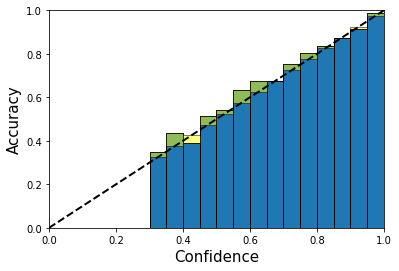

######## MCE: ##############
Local MCE: 0.059259259259259234


In [ ]:
store_local=[]
templ=np.max(y_local_te,axis=1)
dr=0.05
for ratio in np.arange(0,1,dr):
    index=(templ>ratio)*(templ<ratio+dr)
    store_local.append(np.mean(y_local_te_single[index]==targets_te[index]))

# some has nan, replace with 0
store_local=np.array(store_local)
store_local[np.isnan(store_local)]=0
#%%
xaxis=np.arange(0,1,dr)+dr/2
plt.bar(xaxis[store_local!=0],store_local[store_local!=0],width=dr, edgecolor="black")
plt.bar(xaxis[store_local!=0],xaxis[store_local!=0]-store_local[store_local!=0],bottom=store_local[store_local!=0],width=dr, edgecolor="black",color='yellow',alpha=0.5)
plt.bar(10,10,bottom=store_local,width=dr, edgecolor="black",color='green',alpha=0.5)
plt.plot([0,1],[0,1],color='black',linewidth=2,linestyle='dashed')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
#plt.legend(('Perfect calibration','Accuracy','Over-confidence','Under-confidence'),fontsize=13,frameon=0)
plt.savefig('Confidence_CIFAR10_detail_LOCAL.pdf',format='pdf')
plt.show()
#%%
print("######## MCE: ##############")
print(f"Local MCE: {np.max(np.abs(xaxis[store_local!=0]-store_local[store_local!=0]))}")


In [ ]:
class Args:
  batch_size=256;
  test_batch_size=1000;
  epochs=15
  n_runs=1
  lr=0.25 # lr SGD
  sigma=1.3
  max_per_sample_grad_norm=1.5
  delta=1e-5
  device='cuda'
  save_model=False
  disable_dp=True
  workers=2
  data_root='/mnist'

args = Args()
device = torch.device(args.device)


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        args.data_root,
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
            ]
        ),
    ),
    batch_size=args.batch_size,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        args.data_root,
        train=False,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
            ]
        ),
    ),
    batch_size=args.test_batch_size,
    shuffle=True,
)
        
tr_loss = np.zeros((args.n_runs,args.epochs))
te_loss = np.zeros((args.n_runs,args.epochs))
te_accu = np.zeros((args.n_runs,args.epochs))
eps = np.zeros((args.n_runs,args.epochs))
for run in range(args.n_runs):
    net = SampleConvNet().to(device)

    optimizer = optim.SGD(net.parameters(), lr=args.lr,weight_decay =0.001)
    if not args.disable_dp:
        privacy_engine = PrivacyEngine(
            net,
            batch_size=args.batch_size,
            sample_size=len(train_loader.dataset),
            alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
            noise_multiplier=1.3,
            max_grad_norm=args.max_per_sample_grad_norm,
        )
        privacy_engine.attach(optimizer)
    for epoch in range(1, args.epochs + 1):
        tr_loss[run,epoch-1],eps[run,epoch-1]=train(args, net, device, train_loader, optimizer, epoch)
        te_loss[run,epoch-1],te_accu[run,epoch-1]=test(args, net, device, test_loader)

if args.n_runs > 1:
    print('Training loss: ',np.mean(tr_loss,axis=0),np.std(tr_loss,axis=0))
    print('Testing loss: ',np.mean(te_loss,axis=0),np.std(te_loss,axis=0))
    print('Testing accuracy: ',np.mean(te_accu,axis=0),np.std(te_accu,axis=0))

plt.plot(np.mean(eps,axis=0),np.mean(te_accu,axis=0))

repro_str = (
    f"{net.name()}_{args.lr}_{args.sigma}_"
    f"{args.max_per_sample_grad_norm}_{args.batch_size}_{args.epochs}_MNIST"
)
torch.save([tr_loss,te_loss,te_accu,eps], f"run_results_{repro_str}.pt")


Train Epoch: 1 	 Loss: 0.628626

Test set: Average loss: 0.0177, Accuracy: 9666/10000 (96.6600%)



KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 	 Loss: 2.302496

Test set: Average loss: 0.3837, Accuracy: 1135/10000 (11.3500%)

Train Epoch: 2 	 Loss: 2.302328

Test set: Average loss: 0.3837, Accuracy: 1135/10000 (11.3500%)

Train Epoch: 3 	 Loss: 2.302348

Test set: Average loss: 0.3837, Accuracy: 1028/10000 (10.2800%)

Train Epoch: 4 	 Loss: 2.302367

Test set: Average loss: 0.3837, Accuracy: 958/10000 (9.5800%)

Train Epoch: 5 	 Loss: 2.302395

Test set: Average loss: 0.3837, Accuracy: 980/10000 (9.8000%)

Train Epoch: 6 	 Loss: 2.302365

Test set: Average loss: 0.3837, Accuracy: 1032/10000 (10.3200%)

Train Epoch: 7 	 Loss: 2.302315

Test set: Average loss: 0.3837, Accuracy: 1010/10000 (10.1000%)

Train Epoch: 8 	 Loss: 2.302376

Test set: Average loss: 0.3837, Accuracy: 1135/10000 (11.3500%)

Train Epoch: 9 	 Loss: 2.302352

Test set: Average loss: 0.3837, Accuracy: 1135/10000 (11.3500%)

Train Epoch: 10 	 Loss: 2.302334

Test set: Average loss: 0.3837, Accuracy: 1135/10000 (11.3500%)

Train Epoch: 11 	 Loss:

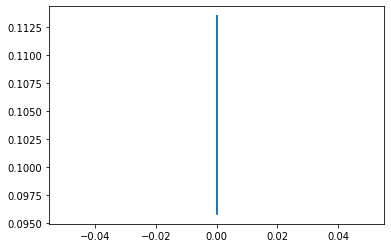

In [ ]:
class Args:
  batch_size=256;
  test_batch_size=1000;
  epochs=15
  n_runs=1
  lr=0.25 # lr SGD
  sigma=1.3
  max_per_sample_grad_norm=1.5
  delta=1e-5
  device='cuda'
  save_model=False
  disable_dp=True
  workers=2
  data_root='/mnist'

args = Args()
device = torch.device(args.device)


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        args.data_root,
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
            ]
        ),
    ),
    batch_size=args.batch_size,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        args.data_root,
        train=False,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
            ]
        ),
    ),
    batch_size=args.test_batch_size,
    shuffle=True,
)
        
tr_loss = np.zeros((args.n_runs,args.epochs))
te_loss = np.zeros((args.n_runs,args.epochs))
te_accu = np.zeros((args.n_runs,args.epochs))
eps = np.zeros((args.n_runs,args.epochs))
for run in range(args.n_runs):
    net = SampleConvNet().to(device)

    optimizer = optim.SGD(net.parameters(), lr=args.lr,weight_decay =1.0)
    if not args.disable_dp:
        privacy_engine = PrivacyEngine(
            net,
            batch_size=args.batch_size,
            sample_size=len(train_loader.dataset),
            alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
            noise_multiplier=1.3,
            max_grad_norm=args.max_per_sample_grad_norm,
        )
        privacy_engine.attach(optimizer)
    for epoch in range(1, args.epochs + 1):
        tr_loss[run,epoch-1],eps[run,epoch-1]=train(args, net, device, train_loader, optimizer, epoch)
        te_loss[run,epoch-1],te_accu[run,epoch-1]=test(args, net, device, test_loader)

if args.n_runs > 1:
    print('Training loss: ',np.mean(tr_loss,axis=0),np.std(tr_loss,axis=0))
    print('Testing loss: ',np.mean(te_loss,axis=0),np.std(te_loss,axis=0))
    print('Testing accuracy: ',np.mean(te_accu,axis=0),np.std(te_accu,axis=0))

plt.plot(np.mean(eps,axis=0),np.mean(te_accu,axis=0))

repro_str = (
    f"{net.name()}_{args.lr}_{args.sigma}_"
    f"{args.max_per_sample_grad_norm}_{args.batch_size}_{args.epochs}_MNIST"
)
torch.save([tr_loss,te_loss,te_accu,eps], f"run_results_{repro_str}.pt")


100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


######## ECE: ##############
Local accuracy: 0.8808, predicted confidence 0.9863048032104968, ECE 0.10550480321049682


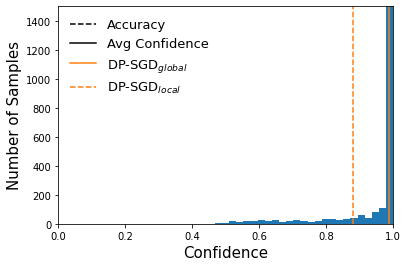

In [ ]:
model_local=net
model_local.eval()
y_local_te=np.empty((0,10))
y_local_te_single=np.array([])
targets_te=np.array([])
prob_local=np.array([])
with torch.no_grad():
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            output = model_local(data)
            y_local_te=np.append(y_local_te,F.softmax(output,dim=1).cpu().detach().numpy(),axis=0)
            y_local_te_single=np.append(y_local_te_single,F.softmax(output,dim=1).argmax(dim=1).cpu().detach().numpy())
            prob_local=np.append(prob_local,np.array([F.softmax(output,dim=1).cpu().detach().numpy()[i,j] for i,j in enumerate(target.cpu().detach().numpy())]))
            targets_te=np.append(targets_te,target.cpu().detach().numpy())


local_acc = np.mean(y_local_te_single == targets_te)
print("######## ECE: ##############")
print(f"Local accuracy: {local_acc}, predicted confidence {np.mean(np.max(y_local_te,axis=1))}, ECE {np.abs(local_acc - np.mean(np.max(y_local_te,axis=1)))}")


plt.plot(0,0,linestyle='dashed',color='black')
plt.plot(0,0,color='black')
plt.plot(0,0,color='#ff7f0e')
plt.plot([np.mean(targets_te==y_local_te_single)]*20,np.linspace(0,1500,20),linestyle='dashed',color='#ff7f0e',label='local Accu')
plt.plot([np.mean(np.max(y_local_te,axis=1))]*20,np.linspace(0,1500,20),color='#ff7f0e')

plt.hist([np.max(y_local_te,axis=1)],bins=30)
plt.ylim(0,1500)
plt.xlim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Number of Samples', fontsize=15)
plt.legend(('Accuracy','Avg Confidence',r'DP-SGD${}_{global}$',r'DP-SGD${}_{local}$'),fontsize=13,loc='upper left',frameon=False)
plt.savefig('Confidence_CIFAR10.pdf',format='pdf')
plt.show()


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


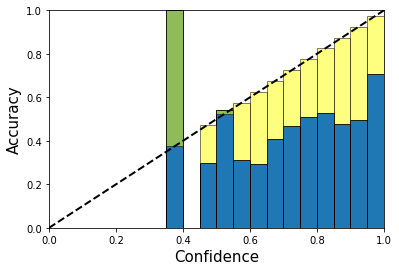

######## MCE: ##############
Local MCE: 0.625


In [ ]:
store_local=[]
templ=np.max(y_local_te,axis=1)
dr=0.05
for ratio in np.arange(0,1,dr):
    index=(templ>ratio)*(templ<ratio+dr)
    store_local.append(np.mean(y_local_te_single[index]==targets_te[index]))

# some has nan, replace with 0
store_local=np.array(store_local)
store_local[np.isnan(store_local)]=0
#%%
xaxis=np.arange(0,1,dr)+dr/2
plt.bar(xaxis[store_local!=0],store_local[store_local!=0],width=dr, edgecolor="black")
plt.bar(xaxis[store_local!=0],xaxis[store_local!=0]-store_local[store_local!=0],bottom=store_local[store_local!=0],width=dr, edgecolor="black",color='yellow',alpha=0.5)
plt.bar(10,10,bottom=store_local,width=dr, edgecolor="black",color='green',alpha=0.5)
plt.plot([0,1],[0,1],color='black',linewidth=2,linestyle='dashed')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
#plt.legend(('Perfect calibration','Accuracy','Over-confidence','Under-confidence'),fontsize=13,frameon=0)
plt.savefig('Confidence_CIFAR10_detail_LOCAL.pdf',format='pdf')
plt.show()
#%%
print("######## MCE: ##############")
print(f"Local MCE: {np.max(np.abs(xaxis[store_local!=0]-store_local[store_local!=0]))}")
